In [ ]:
# https://www.nature.com/articles/s41598-024-54846-8 # A hybrid ResNet‑ViT approach to bridge the global and local features for myocardial infarction detection
# https://github.com/Alousseyni/melanoma-classification-project
# https://medium.com/@james.sc.yan/using-pre-trained-vision-transformer-model-and-resnet-model-as-features-extractors-for-image-2292096e99a
# https://www.kaggle.com/code/gxkok21/resnet50-with-pytorch
# https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/

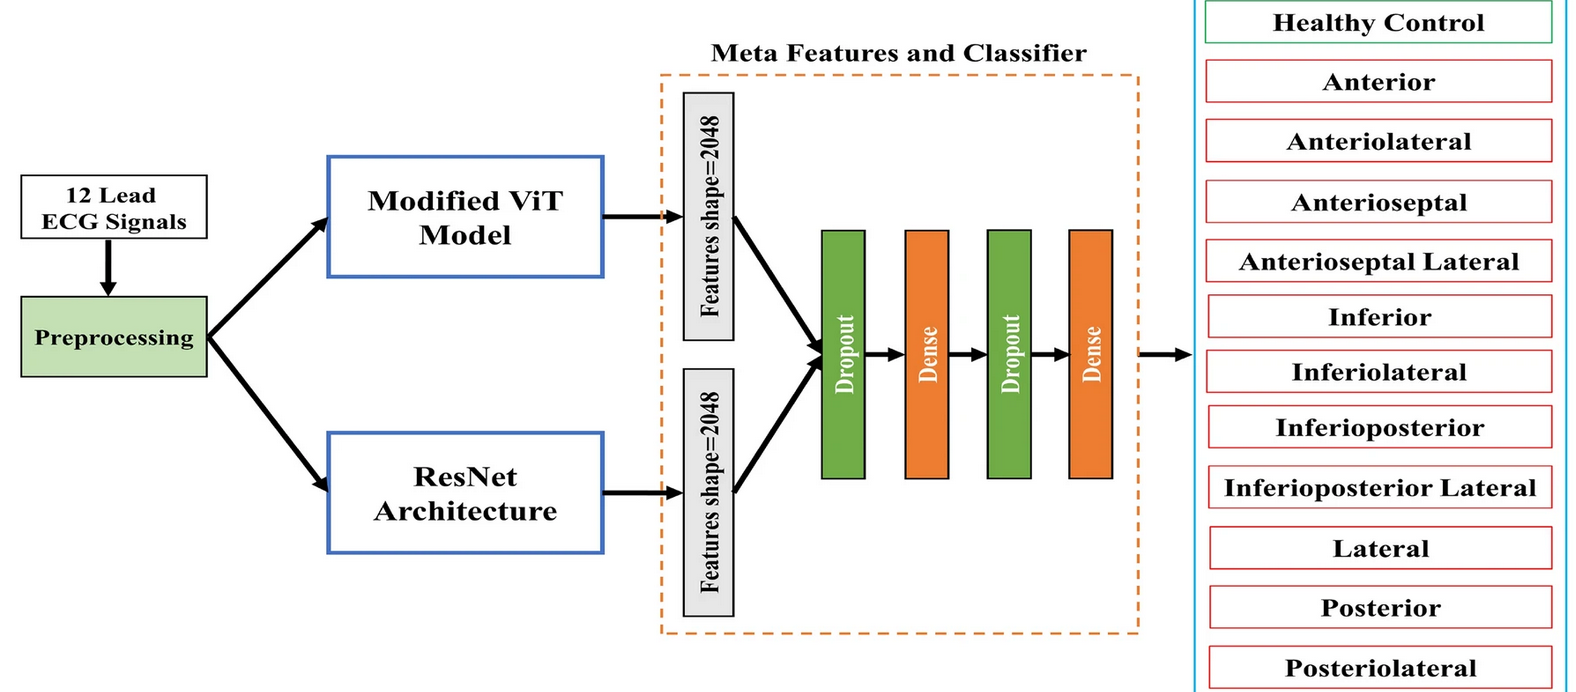

In [1]:
!nvidia-smi

Sat Aug 31 13:32:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -q datasets transformers accelerate torchvision

Modeli ve veri setini yüklemek için login ol

In [3]:
from huggingface_hub import notebook_login
notebook_login()

Kütüphaneleri yükle

In [4]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

from torchvision import models
# dir(models)

import warnings
warnings.filterwarnings('ignore')

hangi aygıttayız cuda var mı paşam!

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


verimizi yükleyelim lütfen önemli!

In [6]:
from datasets import load_dataset
dataset = load_dataset("hongrui/mammogram_v_1")

In [7]:
print(dataset)
# özelliklerim nedir benim ya
print(dataset["train"].features)

DatasetDict({
    train: Dataset({
        features: ['image', 'patient_id', 'laterality', 'view', 'age', 'cancer', 'invasive', 'implant', 'BIRADS', 'density', 'text', 'text2'],
        num_rows: 54706
    })
})
{'image': Image(mode=None, decode=True, id=None), 'patient_id': Value(dtype='int64', id=None), 'laterality': Value(dtype='string', id=None), 'view': Value(dtype='string', id=None), 'age': Value(dtype='float64', id=None), 'cancer': Value(dtype='int64', id=None), 'invasive': Value(dtype='int64', id=None), 'implant': Value(dtype='int64', id=None), 'BIRADS': Value(dtype='float64', id=None), 'density': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'text2': Value(dtype='string', id=None)}


In [8]:
from datasets import load_dataset
import numpy as np
from datasets import Value, Features

# Sadece 'image' ve 'BIRADS' sütunlarını seçin
selected_dataset = dataset['train'].select_columns(['image', 'BIRADS'])
print(selected_dataset)

# None değerlerini -1 ile doldur ve tüm değerleri tam sayıya çevir
def preprocess_birads(example):
    birads = example['BIRADS']
    if birads is None or np.isnan(birads):
        birads = 0
    else:
        birads = int(birads) +1
    example['label'] = int(birads)
    return example

# BIRADS değerlerini işleyin
updated_dataset = selected_dataset.map(preprocess_birads, remove_columns=['BIRADS'])

# Yeni özellik yapısını tanımlayın
new_features = Features({
    'image': updated_dataset.features['image'],  # Mevcut image özelliğini koru
    'label': Value('int64')  # Yeni 'label' sütunu için int64 tipini kullan
})

updated_dataset = updated_dataset.cast(new_features)

# # Sütun tiplerini yeniden belirleyin (image sütunu aynı kalacak)
# features = updated_dataset.features.copy()
# features['BIRADS'] = Value('int32')  # Sütun türünü Value ile tanımla

# # BIRADS sütununu int olarak yeniden tip dönüşümü yapın
# updated_dataset = updated_dataset.cast(features)

# Sonuçları kontrol et
print("Güncellenen veri setindeki benzersiz BIRADS değerleri:")
print(updated_dataset.unique('label'))

Dataset({
    features: ['image', 'BIRADS'],
    num_rows: 54706
})
Güncellenen veri setindeki benzersiz BIRADS değerleri:
[0, 1, 2, 3]


In [9]:
split_dataset = updated_dataset.train_test_split(test_size=0.2, seed=42)

# Sonucu kontrol et
print("Train set:", split_dataset['train'])
print("Test set:", split_dataset['test'])

# İsterseniz, split sonrası veri setlerinin boyutlarını kontrol edebilirsiniz
print("\nTrain set size:", len(split_dataset['train']))
print("Test set size:", len(split_dataset['test']))

Train set: Dataset({
    features: ['image', 'label'],
    num_rows: 43764
})
Test set: Dataset({
    features: ['image', 'label'],
    num_rows: 10942
})

Train set size: 43764
Test set size: 10942


In [10]:
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']
# val_dataset = dataset['test']

In [11]:
print("Train veri seti türü:")
print(type(train_dataset))

# Veri setinin özelliklerini kontrol edelim
print("Train veri seti özellikleri:")
print(train_dataset.features)

print("\nTrain veri setinden ilk örnek:")
print(train_dataset[0])

print("\nTrain veri setindeki benzersiz etiketler:")
print(set(train_dataset['label']))

print("\nTrain veri setinden 'label' örnekleri:")
print(train_dataset['label'][:5])  # İlk 5 etiketi göster

print("\nTrain veri seti etiket dağılımı:")
from collections import Counter
print(Counter(train_dataset['label']))

Train veri seti türü:
<class 'datasets.arrow_dataset.Dataset'>
Train veri seti özellikleri:
{'image': Image(mode=None, decode=True, id=None), 'label': Value(dtype='int64', id=None)}

Train veri setinden ilk örnek:
{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512 at 0x7A4E950B7130>, 'label': 1}

Train veri setindeki benzersiz etiketler:
{0, 1, 2, 3}

Train veri setinden 'label' örnekleri:
[1, 1, 2, 0, 2]

Train veri seti etiket dağılımı:
Counter({0: 22766, 2: 12608, 1: 6581, 3: 1809})


labellarım nedir benim ya :o

In [12]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    Resize,
    ToTensor,
    ColorJitter,
    RandomRotation,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomAutocontrast,
    RandomAdjustSharpness,
    RandomPosterize,
    RandomAffine,
)


# Manuel olarak normalizasyon ve boyut ayarları
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
size = (224, 224)  # Örnek boyut
crop_size = size
max_size = None

# Eğitim için dönüşümler
train_transforms = Compose(
    [
        Resize(size, max_size=max_size),
        # CenterCrop(crop_size),
        RandomHorizontalFlip(p=0.5),
        RandomVerticalFlip(p=0.5),
        RandomPosterize(bits=2, p=0.5),
        RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        RandomAutocontrast(p=0.5),
        # RandomRotation(10),
        ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        # RandomAffine(degrees=5, translate=(0.05, 0.05)),  # Hafif kaydırma ve döndürme
        ToTensor(),
        normalize,
    ]
)

# Doğrulama için dönüşümler
val_transforms = Compose(
    [
        Resize(size, max_size=max_size),
        CenterCrop(crop_size),
        ToTensor(),
        normalize,
    ]
)

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch


In [13]:
train_ds = train_dataset
test_ds = test_dataset
# val_ds = val_dataset

In [14]:
train_ds.set_transform(preprocess_train)
test_ds.set_transform(preprocess_val)
# val_ds.set_transform(preprocess_val)

In [ ]:
train_ds[0]

In [ ]:
example_train = train_ds[0]
example_test = test_ds[0]

print("Train örneği:", example_train["pixel_values"].shape)
print("Test örneği:", example_test["pixel_values"].shape)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class BIRADSDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        # Zaten bir PIL Image nesnesi olduğundan, doğrudan kullanabiliriz.
        image = item['image']
        label = item['label']

        # Eğer tensor olarak kullanmak istiyorsanız, direkt olarak 'pixel_values' kullanabilirsiniz
        if 'pixel_values' in item:
            image = item['pixel_values']
        elif self.transform:
            image = self.transform(image)

        return image, label

def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    return images, labels

# Veri setlerini oluşturalım
train_dataset = BIRADSDataset(train_ds, transform=train_transforms)
test_dataset = BIRADSDataset(test_ds, transform=val_transforms)

# DataLoader'ları oluşturalım
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)

sample_batch, sample_labels = next(iter(train_loader))
sample_batch = sample_batch.to(device)
sample_labels = sample_labels.to(device)

print(f"Girdi şekli: {sample_batch.shape}")
print(f"Etiket şekli: {sample_labels.shape}")

Modelleri kuralım

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import convnext_base, vit_b_16, resnet50
from torchvision.models import ConvNeXt_Base_Weights, ViT_B_16_Weights, ResNet50_Weights
from tqdm import tqdm

In [29]:
# Feature Extraction sınıfı
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Feature extraction için son katmanları kaldıralım
        self.vit.heads = nn.Identity()
        self.resnet.fc = nn.Identity()

    def forward(self, x):
        vit_features = self.vit(x)
        resnet_features = self.resnet(x)
        return torch.cat((vit_features, resnet_features), dim=1) # modelleri birleştirelim

MLP modelleri burada

In [30]:
# Basit bir MLP modeli
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [31]:
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.2):
        super(DeepMLP, self).__init__()
        self.layers = nn.ModuleList()

        # Giriş katmanı
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.LayerNorm(hidden_sizes[0]))
        self.layers.append(nn.Dropout(dropout_rate))

        # Gizli katmanlar
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.LayerNorm(hidden_sizes[i]))
            self.layers.append(nn.Dropout(dropout_rate))

        # Çıkış katmanı
        self.layers.append(nn.Linear(hidden_sizes[-1], num_classes))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

feature extraction ve derin öğrenme modelini birleştir

In [ ]:
# Kombinasyon modeli
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.mlp = MLP(input_size=768+2048, num_classes=num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.mlp(features)
        return output

In [32]:
# Kombinasyon modeli
class CombinedModel(nn.Module):
    def __init__(self, num_classes, hidden_sizes=[1024, 512, 256, 128, 64]):
        super(CombinedModel, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.mlp = DeepMLP(input_size=768+2048, hidden_sizes=hidden_sizes, num_classes=num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.mlp(features)
        return output

train fonksiyonu buradadır

In [33]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # tqdm ile ilerleme çubuğu oluştur
    pbar = tqdm(train_loader, desc="Training")

    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # İlerleme çubuğunu güncelle
        current_loss = running_loss / (pbar.n + 1)
        current_acc = 100. * correct / total
        pbar.set_postfix({'loss': f'{current_loss:.4f}', 'acc': f'{current_acc:.2f}%'})

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

# # Değerlendirme fonksiyonu
# def evaluate(model, test_loader, criterion, device):
#     model.eval()
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)

#             running_loss += loss.item()
#             _, predicted = outputs.max(1)
#             total += labels.size(0)
#             correct += predicted.eq(labels).sum().item()

#     epoch_loss = running_loss / len(test_loader)
#     epoch_acc = 100. * correct / total
#     return epoch_loss, epoch_acc


def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrikleri hesapla
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_predictions) * 100  # Yüzde olarak
    precision = precision_score(all_labels, all_predictions, average='weighted') * 100  # Yüzde olarak
    recall = recall_score(all_labels, all_predictions, average='weighted') * 100  # Yüzde olarak
    f1 = f1_score(all_labels, all_predictions, average='weighted') * 100  # Yüzde olarak

    epoch_loss = running_loss / len(test_loader)

    return {
        'loss': epoch_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [35]:
# Model, loss function ve optimizer'ı oluştur
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CombinedModel(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001) # adaW # sgd veya başka optim örnekleri ekle
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)

In [36]:
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
# Eğitim döngüsü
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    # print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    val_metrics = evaluate(model, test_loader, criterion, device)
    print(f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.2f}%")
    print(f"Val Precision: {val_metrics['precision']:.2f}%, Val Recall: {val_metrics['recall']:.2f}%, Val F1: {val_metrics['f1']:.2f}%")
    print("-" * 50)
    print()

# Modeli kaydet
torch.save(model.state_dict(), "birads_classification_combined_model_vit_resnet50_adamW.pth")

In [ ]:
import torch

# Model sınıfını ve parametreleri aynı şekilde tanımlamalısın
model = CombinedModel(num_classes=4).to(device)  # Sınıf sayısını senin modeline göre ayarla
model.load_state_dict(torch.load("birads_classification_combined_model_vit_resnet50_adamW.pth"))
model.eval()  # Modeli evaluation moduna al


In [ ]:
import numpy as np

# Tahminler ve gerçek etiketler için listeler oluştur
all_predictions = []
all_labels = []
all_probs = []  # ROC eğrisi için olasılıkları saklayacağız

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Verileri cihaza taşı

        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)  # Olasılıkları elde et
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # Olasılıkları listeye ekle


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Etiketleri binarize et
all_labels_bin = label_binarize(all_labels, classes=[1, 2, 4, 5])  # Sınıf sayını ayarla

# ROC eğrisini çiz
plt.figure(figsize=(10, 8))

for i in range(4):  # Her sınıf için
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Rastgele tahmin çizgisi
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Karışıklık matrisini oluştur
cm = confusion_matrix(all_labels, all_predictions)

# Karışıklık matrisini çiz
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 4, 5])  # Sınıf sayını ayarla
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()